# Modeling
In this notebook, I will test different models on the datasets to find an optimal model for classification of dadjokes and antijokes.

### Contents
- [Import Libraries and Dataset](#Import-Libraries-and-Dataset)
- [Prepare Data for NLP Modeling](#Prepare-Data-for-NLP-Modeling)
- [Choosing Classification Models](#Choosing-Classification-Models)
- [Defining Common Functions](#Defining-Common-Functions)
- [Modeling Using CountVectorizer](#Modeling-Using-CountVectorizer)
    - [Without Hyperparameter Tuning](#Without-Hyperparameter-Tuning)
    - [ With Hyperparameter Tuning](#With-Hyperparameter-Tuning)
    - [Statistics of Models using CountVectorizer](#Statistics-of-Models-using-CountVectorizer)
- [Modeling Using TfidfVectorizer](#Modeling-Using-TfidfVectorizer)
    - [Without Hyperparameter Tuning](#Without-Hyperparameter-Tuning)
    - [With Hyperparameter Tuning](#With-Hyperparameter-Tuning)
    - [Statistics of Models using TfidfVectorizer](#Statistics-of-Models-using-TfidfVectorizer)
- [All Models Statistics](#All-Models-Statistics)
- [Production Model](#Production-Model)
- [Conclusion and Business Impact](#Conclusion-and-Business-Impact)


##  Import Libraries and Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, f1_score, recall_score, precision_score

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

In [2]:
dadjokes = pd.read_csv('../datasets/dadjokes_cleaned.csv')
antijokes = pd.read_csv('../datasets/antijokes_cleaned.csv')

## Prepare Data for NLP Modeling

In [3]:
# combine the antijokes and datajokes dataset into a ccombined dataset
combined_df = pd.concat([dadjokes, antijokes])

# reset the combined dataset's index
combined_df.reset_index(drop=True, inplace=True)

# create a column for the target
# 1 if the row is dadjokes, 0 if the row is antijokes
combined_df['target'] = combined_df['subreddit'].map({'dadjokes': 1, 'AntiJokes': 0})

combined_df.head()

,subreddit,original_title,original_post,url,title,title_len,post,post_len,combined,target
0,dadjokes,Why is all the toilet paper running out in sto...,It’s because of all the a**holes.,https://www.reddit.com/r/dadjokes/comments/jym...,why is all the toilet paper running out in store,10,it s because of all the a hole,8,why is all the toilet paper running out in sto...,1
1,dadjokes,"A thief broke into a guy's house, stole his st...",… he was mugged.,https://www.reddit.com/r/dadjokes/comments/k0j...,a thief broke into a guy s house stole his stu...,21,he wa mugged,3,a thief broke into a guy s house stole his stu...,1
2,dadjokes,Why is it called a paternity test...,....and not pop quiz.,https://www.reddit.com/r/dadjokes/comments/k2x...,why is it called a paternity test,7,and not pop quiz,4,why is it called a paternity test and not pop ...,1
3,dadjokes,THE LAND MINE WAS A....,GROUND BREAKING DISCOVERY,https://www.reddit.com/r/dadjokes/comments/jxn...,the land mine wa a,5,ground breaking discovery,3,the land mine wa a ground breaking discovery,1
4,dadjokes,Did you hear about the color bomb?,Yeah it blue up.,https://www.reddit.com/r/dadjokes/comments/k1c...,did you hear about the color bomb,7,yeah it blue up,4,did you hear about the color bomb yeah it blue up,1


In [4]:
# create the X and y variables
X = combined_df['combined'].copy()
y = combined_df['target'].copy()

In [5]:
# train test split to create a training set and testing set to the test the model
# stratify the split according to the target to have the same proportion of dadjokes and antijokes in both dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)

In [6]:
# check the proportion of dadjokes and antijokes in training set
y_train.value_counts(normalize=True)

1    0.500481
0    0.499519
Name: target, dtype: float64

In [7]:
# check the proportion of dadjokes and antijokes in the testing set
y_test.value_counts(normalize=True)

1    0.5
0    0.5
Name: target, dtype: float64

The above also mean that if we were to predict all items as dadjokes, we will have an accuracy of 50%.

Hence, the **baseline model has an accuracy of 50%**.

## Choosing Classification Models
I will try the following models, which are suitable for **classification problems**:
1. LogisticRegression
2. KNeighborsClassifier
3. DecisionTreeClassifier
4. BaggingClassifier
5. RandomForestClassifier
6. AdaBoostClassifier

\
**Classification Metric**

For this project, I will be using **F1-score** as I am interested in obtaining:
1. The **highest amount of accurately predicted dadjokes** (True Positives).
2. The **least amount of inaccurately predicted dadjokes** (False Positives). Reason: Person sorting through the jokkes will have to spend less time looking through the antijokes.
3. The least amount of inaccurately predicted antijokes (False Negatives). Reason: Might miss a good dadjoke if this is too high (although this is less important).

As such, **F1-score**, which is the **harmonic mean of Precision and Recall**, is the best metric to optimize for the above and is chosen.

\
I will also look at Accuracy, Recall, Precision separately.
- Accuracy: All Accurate Prediction / All Predictions
- **Precision (more important)**: True Positive / All Predicted Positives.
- Recall (less important): True Positives / All Actual Positives.

In [8]:
# create a dict of model 
model_dict = {"Logistic Regression": LogisticRegression(),
              "K Nearest Neighbors": KNeighborsClassifier(),
              "Multinomial NB": MultinomialNB(),
              "Decision Tree": DecisionTreeClassifier(random_state = 11),
              "Bag of Trees": BaggingClassifier(random_state = 11),
              "Random Forest": RandomForestClassifier(random_state = 11),
              }

# create a temporary dictionary to store the results of the models
temp_dict = {'Model': [],
            'F1 Score': []}

# loop through the models in the dictionary and run them in a pipeline with CountVectorizer
for name, model in model_dict.items():
    pipe = Pipeline([('cvec', CountVectorizer()),
                     (name, model)])

    pipe.fit(X_train, y_train)
    
    # find the f1 score of the model
    score = f1_score(y_test, pipe.predict(X_test))
    
    # append the model and the f1 score to the dictionary
    temp_dict['Model'].append(name)
    temp_dict['F1 Score'].append(round(score, 4))

pd.DataFrame(temp_dict)

,Model,F1 Score
0,Logistic Regression,0.6950
1,K Nearest Neighbors,0.5118
2,Multinomial NB,0.6396
3,Decision Tree,0.6207
4,Bag of Trees,0.6224
5,Random Forest,0.7212


**Models to be Tested**

Based on the results from the non-optimized models, the following models **produced better results**:
1. Logistic Regression
2. Multinominal Naive Bayes
3. Random Forest (out of Tree Models)

I will use the above 3 models for subsequent modeling. For each of the above model, I will:
1. try **GridSearchCV (or RandomSearchCV)** to test effect of **different combination of hyperparameters**.
2. carry out the modeling with **both CountVectorizer and TfidfVectorizer** to see which text vectorizer will produce a better result.

During GridSearch, I will try to reduce the overfitting in the model by trying different values for hyperparameters.

## Defining Common Functions

In [9]:
# create a function that runs GridSearchCV on a model/pipeline

def run_gridsearch(model, params):
    
    '''
    function to run GridSearchCV given a model and a list of parameters
    prints the best parameters
    returns the best estimator
    '''
    
    # scoring set to f1-score
    grid = GridSearchCV(model,
                        param_grid=params,
                        scoring='f1',
                        n_jobs=-2,
                        cv=5,
                        verbose=0)

    grid.fit(X_train, y_train)

    print(grid.best_params_)

    best_model = grid.best_estimator_

    return best_model

In [10]:
# create a function that runs a RandomizedSearchCV on a model/pipeline
# used if there are too many combinations of hyperparameters

def run_randsearch(model, params, combi):

    '''
    function to run RandomizedSearchCV given a model and a list of parameters
    prints the best parameters
    returns the best estimator
    '''
    grid = RandomizedSearchCV(model,
                              param_distributions=params,
                              scoring='f1',
                              n_jobs=-2,
                              n_iter=combi,
                              cv=5,
                              random_state=11,
                              verbose=0)

    grid.fit(X_train, y_train)

    print(grid.best_params_)

    best_model = grid.best_estimator_

    return best_model

In [11]:
# create a function that calculates model statistics 
# such as f1-score, accuracy, precision and recall

def get_model_stats(model):
    
    # saves the model statistics into a dictionary
    model_stats = {}
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    # calculate, print and save the f1-score
    # the results are printed to check for overfitting.
    train_f1 = round(f1_score(y_train, pred_train), 4)
    train_f1_cv = round(np.mean(cross_val_score(model, X_train, y_train, scoring='f1')), 4)
    test_f1 = round(f1_score(y_test, pred_test), 4)
    print(f'Train F1 Score: {train_f1}')
    print(f'Train F1 Score (CV): {train_f1_cv}')
    print(f'Test F1 Score: {test_f1}')
    
    model_stats['Train F1'] = train_f1
    model_stats['Train F1 (CV)'] = train_f1_cv
    model_stats['Test F1'] = test_f1
        
    
    # calculate and save the precision score
    train_precision = round(precision_score(y_train, pred_train), 4)
    train_precision_cv = round(np.mean(cross_val_score(model, X_train, y_train, scoring='precision')), 4)
    test_precision = round(precision_score(y_test, pred_test), 4)
    
    model_stats['Train Precision'] = train_precision
    model_stats['Train Precision (CV)'] = train_precision_cv
    model_stats['Test Precision'] = test_precision
    
    
    # calculate and save the recall score
    train_recall = round(recall_score(y_train, pred_train), 4)
    train_recall_score_cv = round(np.mean(cross_val_score(model, X_train, y_train, scoring='recall')), 4)
    test_recall_score = round(recall_score(y_test, pred_test), 4)
    
    model_stats['Train Recall'] = train_recall
    model_stats['Train Recall (CV)'] = train_recall_score_cv
    model_stats['Test Recall'] = test_recall_score
    
    
    # calculate and save the accuracy score
    train_accuracy = round(model.score(X_train, y_train), 4)
    test_accuracy = round(model.score(X_test, y_test), 4)
    
    model_stats['Train Accuracy'] = train_accuracy
    model_stats['Test Accuracy'] = test_accuracy

    
    # calculate and save all the predictions (for reference if necessary)
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, pred_train).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, pred_test).ravel()

    model_stats['Train True Positive'] = tp_train
    model_stats['Train False Positive'] = fp_train
    model_stats['Train False Negative'] = fn_train
    model_stats['Train True Negative'] = tn_train
    model_stats['Test True Positive'] = tp_test
    model_stats['Test False Positive'] = fp_test
    model_stats['Test False Negative'] = fn_test
    model_stats['Test True Negative'] = tn_test

    return model_stats

## Modeling Using CountVectorizer
CountVectorizer basically **converts a collection of text documents to a matrix of token counts** so that the data can be used in ML algorithms.

In [12]:
# create a dictionary to save the model statistics for models using CountVectorizer
cvec_models_stats = {}

# check the number of terms there will be after CountVectorizer
cvec = CountVectorizer()
cvec.fit_transform(X_train).shape

(1039, 3331)

As there is a total of 3331 terms after transforming the training dataset with CountVectorizer, I will try **max_features values with 1000, 2000 and 3000**.

### Without Hyperparameter Tuning

#### Logistic Regression

In [13]:
# get a benchmark statistics of Logistic Regression without hyperparameters tuning
cvec_log_pipe = Pipeline([('cvec', CountVectorizer(lowercase=False)),
                          ('lr', LogisticRegression())])


cvec_log_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(lowercase=False)),
                ('lr', LogisticRegression())])

In [14]:
# get the model statistics
cvec_models_stats['CVec Logistic Regression Pipeline'] = get_model_stats(cvec_log_pipe)

Train F1 Score: 0.9885
Train F1 Score (CV): 0.714
Test F1 Score: 0.695


The model is extremely **overfitted** as:
- **F1 score** on the training dataset is **0.99**
- **Cross-Validated F1 score** on the (same) training dataset is **0.71**

#### Multinominal Naive Bayes

In [15]:
# get a benchmark statistics of Multinomial NB without hyperparameters tuning
cvec_mnb_pipe = Pipeline([('cvec', CountVectorizer(lowercase=False)),
                          ('mnb', MultinomialNB())])


cvec_mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(lowercase=False)),
                ('mnb', MultinomialNB())])

In [16]:
# get the model statistics
cvec_models_stats['CVec Multinomial NB Pipeline'] = get_model_stats(cvec_mnb_pipe)

Train F1 Score: 0.9478
Train F1 Score (CV): 0.6636
Test F1 Score: 0.6396


The model is extremely **overfitted** as:
- **F1 score** on the training dataset is **0.95**
- **Cross-Validated F1 score** on the (same) training dataset is **0.67**

#### Random Forest

In [17]:
# get a benchmark statistics of Random Forest without hyperparameters tuning
cvec_rf_pipe = Pipeline([('cvec', CountVectorizer(lowercase=False)),
                         ('rf', RandomForestClassifier(random_state=11))])


cvec_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('cvec', CountVectorizer(lowercase=False)),
                ('rf', RandomForestClassifier(random_state=11))])

In [18]:
# get the model statistics
cvec_models_stats['CVec Random Forest Pipeline'] = get_model_stats(cvec_rf_pipe)

Train F1 Score: 1.0
Train F1 Score (CV): 0.7163
Test F1 Score: 0.7212


The model is extremely **overfitted** as:
- **F1 score** on the training dataset is **0.99**
- **Cross-Validated F1 score** on the (same) training dataset is **0.71**

### With Hyperparameter Tuning
I will run GridSearchCV (or RandomizedSearchCV) on a set of hyperparameters to reduce the overfitting and improve the f1 score.

Some **hyperparameters** that I will try to tune for CountVectorizer are:
1. stop_words - Whether to remove stopwords
2. ngram-range - Whether to use bi-gram, tri-gram, etc
3. max_df - Whether to ignore terms that have frequency above than a certain threshold
4. min_df - Whether to ignore terms that have frequency lower than a certain threshold 
5. max_features - The number of top terms to be connsidered

I will also tune some hyperparameters specific to each model.

#### Logistic Regression

In [19]:
# list of hyperparameters for the Logistic Regression pipeline
cvec_log_grid_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__max_df': [.98, .96],
    'cvec__min_df': [10, 11, 12],
    'cvec__max_features': [1000, 2000, 3000],
    'lr__C': [0.01, 0.1, 1, 10]
}

# run gridsearch on the pipeline
cvec_log_model = run_gridsearch(cvec_log_pipe, cvec_log_grid_params)

{'cvec__max_df': 0.98, 'cvec__max_features': 1000, 'cvec__min_df': 10, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None, 'lr__C': 0.01}


In [20]:
# get the model statistics
cvec_models_stats['CVec Logistic Regression GridSearch'] = get_model_stats(cvec_log_model)

Train F1 Score: 0.7216
Train F1 Score (CV): 0.6882
Test F1 Score: 0.7286


Observations will be made in the next section.

#### Multinominal Naive Bayes

In [21]:
# list of hyperparameters for the Multinominal NB pipeline
cvec_mnb_grid_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__max_df': [0.98, 0.97, 0.96],
    'cvec__min_df': [10, 11, 12],
    'cvec__max_features': [1000, 2000, 3000]
}

# run gridsearch on the pipeline
cvec_mnb_model = run_gridsearch(cvec_mnb_pipe, cvec_mnb_grid_params)

{'cvec__max_df': 0.98, 'cvec__max_features': 1000, 'cvec__min_df': 11, 'cvec__ngram_range': (1, 3), 'cvec__stop_words': None}


In [22]:
# get the model statistics
cvec_models_stats['CVec Multinomial NB GridSearch'] = get_model_stats(cvec_mnb_model)

Train F1 Score: 0.7464
Train F1 Score (CV): 0.6933
Test F1 Score: 0.724


Observations will be made in the next section.

#### Random Forest

In [23]:
# list of hyperparameters for the Ranndom Forest pipeline
cvec_rf_grid_params = {
    'cvec__stop_words': [None, 'english'],
    'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'cvec__max_df': [0.98, 0.97],
    'cvec__min_df': [2, 3, 4],
    'cvec__max_features': [1000, 2000, 3000],
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [10, 15, 20],
    'rf__min_samples_split': [10, 12, 15],
    'rf__min_samples_leaf': [4, 6]
}

# run randomized search on the pipeline (too many hyperparameters combinations)
cvec_rf_model = run_randsearch(cvec_rf_pipe, cvec_rf_grid_params, combi=400)

{'rf__n_estimators': 100, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 10, 'cvec__stop_words': None, 'cvec__ngram_range': (1, 3), 'cvec__min_df': 3, 'cvec__max_features': 1000, 'cvec__max_df': 0.97}


In [24]:
# get the model statistics
cvec_models_stats['CVec Random Forest GridSearch'] = get_model_stats(cvec_rf_model)

Train F1 Score: 0.7601
Train F1 Score (CV): 0.7187
Test F1 Score: 0.745


Observations will be made in the next section.

### Statistics of Models using CountVectorizer

In [25]:
# create a dataframe of the model statistics
cvec_stats = pd.DataFrame(cvec_models_stats).T

# display only up to Recall metrics
# information such as True Positives, etc will be used only if needed
cvec_stats.iloc[:, :11]

,Train F1,Train F1 (CV),Test F1,Train Precision,Train Precision (CV),Test Precision,Train Recall,Train Recall (CV),Test Recall,Train Accuracy,Test Accuracy
CVec Logistic Regression Pipeline,0.9885,0.7140,0.6950,0.9866,0.7194,0.6977,0.9904,0.7096,0.6923,0.9885,0.6962
CVec Multinomial NB Pipeline,0.9478,0.6636,0.6396,0.9533,0.7286,0.7717,0.9423,0.6096,0.5462,0.9480,0.6923
CVec Random Forest Pipeline,1.0000,0.7163,0.7212,1.0000,0.6946,0.6978,1.0000,0.7404,0.7462,1.0000,0.7115
CVec Logistic Regression GridSearch,0.7216,0.6882,0.7286,0.6888,0.6588,0.7050,0.7577,0.7212,0.7538,0.7074,0.7192
CVec Multinomial NB GridSearch,0.7464,0.6933,0.7240,0.6967,0.6486,0.6779,0.8038,0.7462,0.7769,0.7267,0.7038
CVec Random Forest GridSearch,0.7601,0.7187,0.7450,0.6777,0.6369,0.6607,0.8654,0.8250,0.8538,0.7267,0.7077


**Observations**

- All the **models without hyperparameter tuning are extremely overfitted**. This is evident from the difference between the scores on the whole training dataset vs the cross-validated scores on the same training dataset or the scores from the testing dataset.
- After hyperparameter tuning, the **overfitting has been reduced significantly**. Although there is still some amounts of it remaining, I was unable to reduce it further. This could be due to the techniques employed.
- Among the three models with hyperparameter tuning (with grid search), Logistic Regression performs the best with the **least amount of evidence of overfitting** with **higher precision score**.
    
I will also repeat the same process using TfidfVectorizer.

## Modeling Using TfidfVectorizer

TF-IDF is an abbreviation for **Term Frequency Inverse Document Frequency**. 

TfidfVectorizer is similar to CountVectorizer in that it converts a collection of text documents to a matrix of token counts so that the data can be used in ML algorithms. In fact, the first step of TfidfVectorizer is a CountVectorizer transformation.

However, TfidfVectorizer has an additional second step/process that gives a **measure of the originality/relative importance** of each word by comparing the number of times a word appears in a document/text with and the number of documents/texts that the word appears in. This is as opposed to giving the word frequency from the CountVectorizer.

The additional may provide more useful information that the ML algorithm may learn from to provide better results.

In [26]:
# create a dictionary to save the model statistics for models using TfidfVectorizer
tvec_models_stats = {}

### Without Hyperparameter Tuning

#### Logistic Regression

In [27]:
# get a benchmark statistics of Logistic Regression without hyperparameters tuning
tvec_log_pipe = Pipeline([('tvec', TfidfVectorizer(lowercase=False)),
                          ('lr', LogisticRegression())])


tvec_log_pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(lowercase=False)),
                ('lr', LogisticRegression())])

In [28]:
# get the model statistics
tvec_models_stats['TVec Logistic Regression Pipeline'] = get_model_stats(tvec_log_pipe)

Train F1 Score: 0.9261
Train F1 Score (CV): 0.6891
Test F1 Score: 0.6911


The model is extremely **overfitted** as:
- **F1 score** on the training dataset is **0.93**
- **Cross-Validated F1 score** on the (same) training dataset is **0.71**

#### Multinominal Naive Bayes

In [29]:
# get a benchmark statistics of Multinomial NB without hyperparameters tuning
tvec_mnb_pipe = Pipeline([('tvec', TfidfVectorizer(lowercase=False)),
                          ('mnb', MultinomialNB())])


tvec_mnb_pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(lowercase=False)),
                ('mnb', MultinomialNB())])

In [30]:
# get the model statistics
tvec_models_stats['TVec Multinomial NB Pipeline'] = get_model_stats(tvec_mnb_pipe)

Train F1 Score: 0.9543
Train F1 Score (CV): 0.6551
Test F1 Score: 0.6244


The model is extremely **overfitted** as:
- **F1 score** on the training dataset is **0.95**
- **Cross-Validated F1 score** on the (same) training dataset is **0.65**

#### Random Forest

In [31]:
# get a benchmark statistics of Random Forest without hyperparameters tuning
tvec_rf_pipe = Pipeline([('tvec', TfidfVectorizer(lowercase=False)),
                         ('rf', RandomForestClassifier(random_state=11))])


tvec_rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('tvec', TfidfVectorizer(lowercase=False)),
                ('rf', RandomForestClassifier(random_state=11))])

In [32]:
# get the model statistics
tvec_models_stats['TVec Random Forest Pipeline'] = get_model_stats(tvec_rf_pipe)

Train F1 Score: 1.0
Train F1 Score (CV): 0.6833
Test F1 Score: 0.6923


The model is extremely **overfitted** as:
- **F1 score** on the training dataset is **1.00**
- **Cross-Validated F1 score** on the (same) training dataset is **0.68**

### With Hyperparameter Tuning
The hyperparameters that I will try to tune for TfidfVectorizer are the same as CountVectorizer:

    stop_words - Whether to remove stopwords
    ngram-range - Whether to use bi-gram, tri-gram, etc
    max_df - Whether to ignore terms that have frequency above than a certain threshold
    min_df - Whether to ignore terms that have frequency lower than a certain threshold
    max_features - The number of top terms to be connsidered
    
I will also tune some hyperparameters specific to each model.

#### Logistic Regression

In [33]:
# list of hyperparameters for the Logistic Regression pipeline
tvec_log_pipe_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tvec__max_df': [0.98, 0.97, 0.96],
    'tvec__min_df': [10, 11, 12],
    'tvec__max_features': [1000, 2000, 3000],
    'lr__C': [0.01, 0.1, 1, 10]
}

# run gridsearch on the pipeline
tvec_log_model = run_gridsearch(tvec_log_pipe, tvec_log_pipe_params)

{'lr__C': 0.01, 'tvec__max_df': 0.98, 'tvec__max_features': 1000, 'tvec__min_df': 11, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [34]:
# get the model statistics
tvec_models_stats['TVec Logistic Regression GridSearch'] = get_model_stats(tvec_log_model)

Train F1 Score: 0.7338
Train F1 Score (CV): 0.6919
Test F1 Score: 0.7286


Observations will be made in the next section.

#### Multinominal Naive Bayes

In [35]:
# list of hyperparameters for the Multinominal NB pipeline
tvec_mnb_grid_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'tvec__max_df': [0.98, 0.97, 0.96],
    'tvec__min_df': [10, 11, 12],
    'tvec__max_features': [1000, 2000, 3000]
}

# run gridsearch on the pipeline
tvec_mnb_model = run_gridsearch(tvec_mnb_pipe, tvec_mnb_grid_params)

{'tvec__max_df': 0.98, 'tvec__max_features': 1000, 'tvec__min_df': 10, 'tvec__ngram_range': (1, 3), 'tvec__stop_words': None}


In [36]:
# get the model statistics
tvec_models_stats['TVec Multinomial NB GridSearch'] = get_model_stats(tvec_mnb_model)

Train F1 Score: 0.7647
Train F1 Score (CV): 0.6777
Test F1 Score: 0.7007


Observations will be made in the next section.

#### Random Forest

In [37]:
# list of hyperparameters for the Random Forest pipeline
tvec_rf_grid_params = {
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 1), (1,2), (1, 3)],
    'tvec__max_df': [0.98, 0.97],
    'tvec__min_df': [3, 4, 5],
    'tvec__max_features': [1000, 2000, 3000],
    'rf__n_estimators': [100, 150],
    'rf__max_depth': [20, 30],
    'rf__min_samples_split': [10, 15],
    'rf__min_samples_leaf': [4, 6]
}

# run randomized search on the pipeline (too many hyperparameters combinations)
tvec_rf_model = run_randsearch(tvec_rf_pipe, tvec_rf_grid_params, combi=400)

{'tvec__stop_words': None, 'tvec__ngram_range': (1, 3), 'tvec__min_df': 5, 'tvec__max_features': 3000, 'tvec__max_df': 0.97, 'rf__n_estimators': 150, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 4, 'rf__max_depth': 20}


In [38]:
# get the model statistics
tvec_models_stats['TVec Random Forest GridSearch'] = get_model_stats(tvec_rf_model)

Train F1 Score: 0.8424
Train F1 Score (CV): 0.7238
Test F1 Score: 0.7626


For this model, I have tried multiple different set of hyperparameters, but I am unable to reduce the overfitting significantly (difference between Train F1 Score and Train F1 score (CV)).

### Statistics of Models using TfidfVectorizer

In [39]:
# create a dataframe of the model statistics
tvec_stats = pd.DataFrame(tvec_models_stats).T

# display only up to Recall metrics
# information such as True Positives, etc will be used only if needed
tvec_stats.iloc[:,:11]

,Train F1,Train F1 (CV),Test F1,Train Precision,Train Precision (CV),Test Precision,Train Recall,Train Recall (CV),Test Recall,Train Accuracy,Test Accuracy
TVec Logistic Regression Pipeline,0.9261,0.6891,0.6911,0.9123,0.7046,0.7328,0.9404,0.6750,0.6538,0.9249,0.7077
TVec Multinomial NB Pipeline,0.9543,0.6551,0.6244,0.9646,0.7460,0.7582,0.9442,0.5846,0.5308,0.9548,0.6808
TVec Random Forest Pipeline,1.0000,0.6833,0.6923,1.0000,0.6822,0.6923,1.0000,0.6846,0.6923,1.0000,0.6923
TVec Logistic Regression GridSearch,0.7338,0.6919,0.7286,0.6998,0.6532,0.7050,0.7712,0.7365,0.7538,0.7199,0.7192
TVec Multinomial NB GridSearch,0.7647,0.6777,0.7007,0.7199,0.6406,0.6667,0.8154,0.7212,0.7385,0.7488,0.6846
TVec Random Forest GridSearch,0.8424,0.7238,0.7626,0.8088,0.6743,0.7162,0.8788,0.7827,0.8154,0.8354,0.7462


**Observations**

- Again, all the **models without hyperparameter tuning are extremely overfitted**.
- After hyperparameter tuning, the **overfitting has been reduced significantly**.
- Among the three models with hyperparameter tuning (with grid search), Logistic Regression again had the **least evidence of overfitting**, and a **decent precision score**.

## All Models Statistics
For the final model, I will want to use the model that:
- is not too overfitted
- has high f1-score
- has high precision

I will be plotting all the statistics of models that went through hyperparameter tuning to do a side by side visual comparison based on the criteria above.

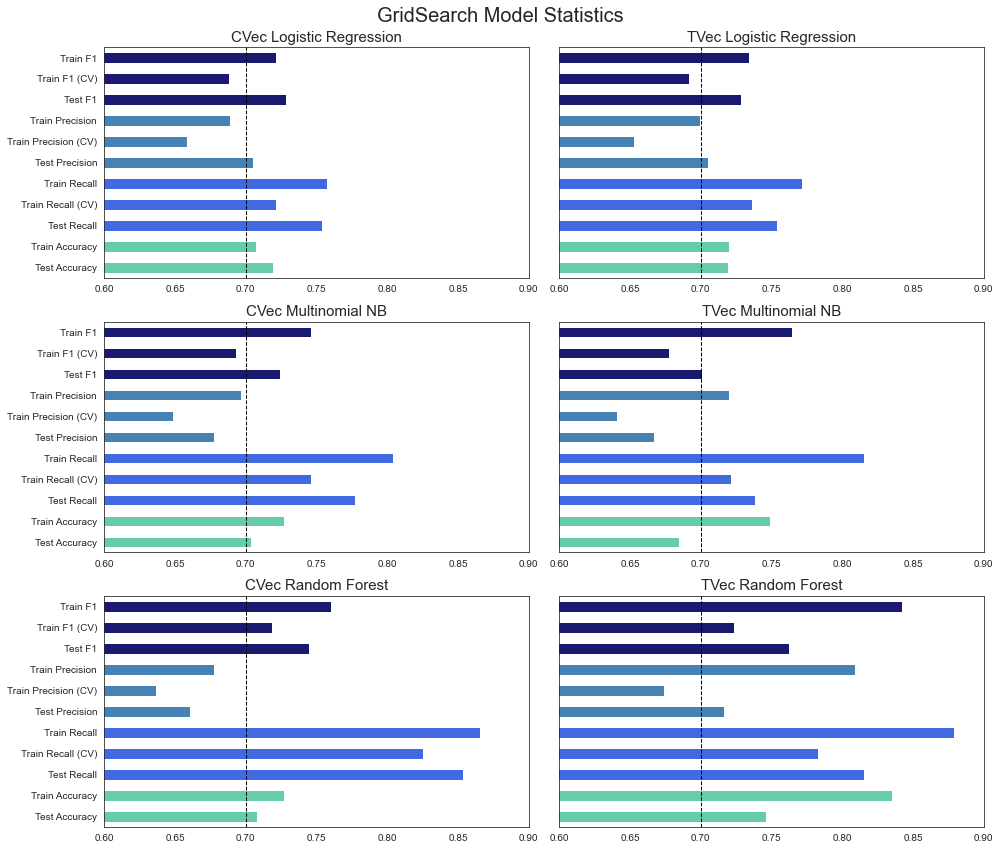

In [40]:
# plot the statistics as a horizonotal barplot

# combine the results for all models using GridSearchCV/RandomizedSearchCV  for comparison
all_stats = pd.concat([cvec_stats.iloc[3:, :11], tvec_stats.iloc[3:, :11]])

# create a temporary dataframe that is the transpose of all_stats
temp_df = all_stats.T

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (14, 12))

# colours to differentiate between the different metrics
color_list = ['midnightblue', 'midnightblue', 'midnightblue', 
              'steelblue','steelblue','steelblue',
              'royalblue','royalblue', 'royalblue', 
              'mediumaquamarine', 'mediumaquamarine', 'mediumaquamarine']

counter = 0

plt.suptitle('GridSearch Model Statistics', fontsize = 20)

# loop through the models and plot them out in horizontal bar plots
for col in temp_df.columns:
    
    # this will arrange all the cvec models are on the left and all tvec models are on the right
    axis = ax[counter%3][int(counter/3)]
    
    temp_df[col].plot(kind='barh', ax=axis, color = color_list)
    axis.set_title(col[:-11], fontsize = 15)
    axis.set_xlim(0.6, .9)
    axis.axvline(x=0.7, linewidth=1, linestyle = '--', color='k', )
    axis.invert_yaxis()
    
    if counter > 2:
        axis.set_yticklabels([])
        
    counter += 1

plt.tight_layout()
plt.show()

**Observations**

Comparing the difference between scores obtained from the whole train dataset vs the scores from the cross-validated train dataset, the **following models have evidence of overfitting and will not be used**:
1. TVec Multinomial NB
2. TVec Random Forest

In [41]:
# print the statistics for the four remaining models
all_stats.iloc[[0, 3, 1, 2]]

,Train F1,Train F1 (CV),Test F1,Train Precision,Train Precision (CV),Test Precision,Train Recall,Train Recall (CV),Test Recall,Train Accuracy,Test Accuracy
CVec Logistic Regression GridSearch,0.7216,0.6882,0.7286,0.6888,0.6588,0.7050,0.7577,0.7212,0.7538,0.7074,0.7192
TVec Logistic Regression GridSearch,0.7338,0.6919,0.7286,0.6998,0.6532,0.7050,0.7712,0.7365,0.7538,0.7199,0.7192
CVec Multinomial NB GridSearch,0.7464,0.6933,0.7240,0.6967,0.6486,0.6779,0.8038,0.7462,0.7769,0.7267,0.7038
CVec Random Forest GridSearch,0.7601,0.7187,0.7450,0.6777,0.6369,0.6607,0.8654,0.8250,0.8538,0.7267,0.7077


Among the four remaining models, Logistic Regression with CountVectorizer has:
1. The **highest precision score**.
2. **High F1 Score**
2. **Relatively low overfitting**


As such, I will use the **Logistic Regression with CountVectorizer with the tuned hyperparameters** for the production model.

# Production Model
I will create a production model using Logistic Regression with CountVectorizer with the tuned hyperparameters found above.

In [42]:
# initialize the CountVectorizer with the hyperparameters found
cvec_prod = CountVectorizer(lowercase=False, max_df=0.98,
                            max_features=1000, min_df=10,
                            ngram_range=(1, 3))

# fit and transform the entire combined text
X_transformed = cvec_prod.fit_transform(X)

# initialiez the Logisticc Regression with the hyperparameters found
lr_prod = LogisticRegression(C=0.01)

# fit the model to the transformed X (text) and y (target)
lr_prod.fit(X_transformed, y)

LogisticRegression(C=0.01)

In [43]:
# find model statistics by cross-validation
print('Cross-validated Model Score')
print('---------------------------')
print(f"F1 Score: {cross_val_score(lr_prod, X_transformed, y, scoring='f1').mean():.3f}")
print(f"Precision Score: {cross_val_score(lr_prod, X_transformed, y, scoring='precision').mean():.3f}")
print(f"Recall Score: {cross_val_score(lr_prod, X_transformed, y, scoring='recall').mean():.3f}")
print(f"Accuracy Score: {cross_val_score(lr_prod, X_transformed, y).mean():.3f}")

Cross-validated Model Score
---------------------------
F1 Score: 0.686
Precision Score: 0.658
Recall Score: 0.717
Accuracy Score: 0.671


In [44]:
# create a list of tuples consisting of the word and its coefficient
words_importance = [(word, lr_prod.coef_[0][index]) for word, index in cvec_prod.vocabulary_.items()]

# create a dataframe using the list
words_importance_df = pd.DataFrame(words_importance, columns=['Word', 'Word Coefficient'])

# set the 'Word' column as index
words_importance_df.set_index('Word', inplace=True)

# create a column that gives the absolute coefficient of each word
words_importance_df['Absolute Word Coefficient'] = abs(words_importance_df['Word Coefficient'])

# sort the dataframe by the absolute coefficient of each word
words_importance_df = words_importance_df.sort_values('Absolute Word Coefficient', ascending=False)

# create a column that gives the change in the odds if the word is present
words_importance_df['Change in Odds'] = np.exp(words_importance_df['Word Coefficient'])

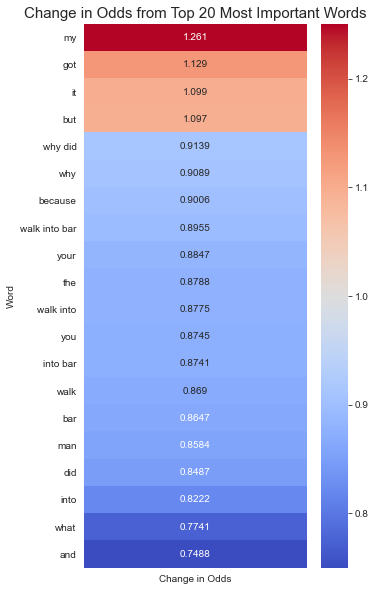

In [45]:
# plot a heatmap of the change in odds
plt.figure(figsize=(5, 10))
sns.heatmap(words_importance_df[:20].sort_values('Change in Odds', ascending = False)[['Change in Odds']], 
            vmin = 0.75, vmax = 1.25, center = 1, annot = True, fmt='.4g',cmap = 'coolwarm', )
plt.title('Change in Odds from Top 20 Most Important Words', fontsize = 15)
plt.show()

# Conclusion

**Model Statistics**

With the **final precision score of 0.658**, this is higher than the baseline model precision of 0.5 by 0.158. This translate to about **24% reduction in time spent** by employee picking dadjokes from a number of jokes containing both dadjokes and antijokes.

The model has a higher recall score of 0.717, which means that the model is in fact better at identifying antijokes than identifying dadjokes. This could be because the antijokes have more "identifiable" words as compared to dadjokes.

\
**Top 20 Words**

Looking at the list of changes in odds of  top 20 words, it becomes apparent why the precision is quite low. Among the top 20 words, **only 4 of the words are identifiers of dadjokes** (with a change in odds above 1), while 16 of them are identifiers of antijokes (with a change in odds below 1).

Surprisingly, the **identifying words for dadjokes are relatively common words** such as: "my", "got", "it", "but". Although, these words had a higher frequency evident from the top N words, I did not expect them to be strong predictors of dadjokes.

On the other hand, **common words like "and", "what", "man", "you", "the" were strong predictors for antijokes**, this was not expected either. However, as expected, jokes with **"walked in a bar" were strong predictors of antijokes**. This was evident from the EDA portion as well. 

\
**Conclusion & Limitations**

This project has obtained a classification model that **performs better than baseline prediction** for the classifying between dadjokes and antijokes. 

However, the classification model **does not have very high precision** as:
1. both of type of jokes use **similar common English words** (not much specialized words)
2. whether a joke is a dadjoke or antijoke is **very context based**, which this model is unable to comprehend

To improve the model, **more sophisticated techniques that tries to explore the context of the jokes could be used**, such as POS tagging.

Furthermore, the amount of records looked at by this project is only about 650 per dataset. With this number of records, it is **easy for the frequency of words to be affected by 1 or 2 entries**. 
- i.e. High frequency of "step step" from 1 single entry in bi-gram
If more entries can be obtained for both dataset, it will help to improve the model to generalize better.